In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import cv2

Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

2.2.0


In [4]:
VALID_FRACTION = 0.2
TEST_FRACTION = 0.33
BATCH_SIZE = 128
EPOCHS = 50

IMAGE_WIDTH = IMAGE_HEIGHT = 256
IMAGE_CHANNELS = 3

In [5]:
train_df = pd.read_csv('../input/1-df-csv/1/train_df.csv')
test_df = pd.read_csv('../input/1-df-csv/1/test_df.csv')
valid_df = pd.read_csv('../input/1-df-csv/1/val_df.csv')
new_df = pd.read_csv('../input/1-df-csv/1/new_df.csv')

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.,)
valid_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)


In [7]:
def generator(samples, batch_size=32,shuffle_data=False, when= 'train'):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        if (shuffle_data):
            shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples.iloc[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples.index:
                # Load image (X) and label (y)
                #print(batch_sample)
                
                img_path = samples.at[batch_sample, 'file_name']
                
                if(when=='train'):
                    
                    img_path = '../input/what-name-1/'+img_path
                
                label = samples.at[batch_sample, 'category']
                #label = to_categorical(label,len(df['english_cname'].unique()))
                #img =  cv2.imread(img_path)
                
                
                #if(when=='train'):
                #    print("{}         {}".format(batch_sample, np.argmax(label)))
                
                # apply any kind of preprocessing                
                #img = cv2.resize(img,(IMG_DIM, IMG_DIM))
                # Add example to arrays
                
                # AUGMENT DATA
                # load the image
                #img = load_img(img_path)
                img =  cv2.imread(img_path)
                #print(img_path)
                img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT))
                #plt.imshow(img)
                # show the figure
                #pyplot.show()
                # convert to numpy array
                image_single = img_to_array(img)
                # expand dimension to one sample
                
                #if(when=='train'):
                image_single = expand_dims(image_single, 0)
                #print(samples.shape)
                # create image data augmentation generator
                

                # prepare iterator
                if (when=='train'):
                    it = train_datagen.flow(image_single, batch_size=1)
                    batch = it.next()
                    image_single = batch[0].astype('float32')
                 
                else:
                    it = valid_datagen.flow(image_single, batch_size = 1)
                    batch = it.next()
                    image_single = batch[0].astype('float32')
               
                    # convert to unsigned integers for viewing
                
                    
                    # plot raw pixel data
                #plt.imshow(image)
                # show the figure
                #pyplot.show()
                
                
                
                
                X_train.append(image_single)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)
            #print("END__________")
            # The generator-y part: yield the next training batch            
            yield X_train, y_train


In [8]:
train_generator = generator(new_df,batch_size=128,shuffle_data=False, when='train')
valid_generator = generator(valid_df, batch_size= 128, shuffle_data=False, when= 'val')


In [9]:
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [10]:
#base_model = tf.keras.applications.MobileNet(input_shape= (256,256,3),include_top=False,weights="imagenet",pooling='average')

base_model = tf.keras.applications.InceptionResNetV2(include_top=False,weights="imagenet",input_shape=(256,256,3),pooling='average')

base_model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_____________

batch_normalization_166 (BatchN (None, 6, 6, 256)    768         conv2d_166[0][0]                 
__________________________________________________________________________________________________
activation_163 (Activation)     (None, 6, 6, 192)    0           batch_normalization_163[0][0]    
__________________________________________________________________________________________________
activation_166 (Activation)     (None, 6, 6, 256)    0           batch_normalization_166[0][0]    
__________________________________________________________________________________________________
block8_1_mixed (Concatenate)    (None, 6, 6, 448)    0           activation_163[0][0]             
                                                                 activation_166[0][0]             
__________________________________________________________________________________________________
block8_1_conv (Conv2D)          (None, 6, 6, 2080)   933920      block8_1_mixed[0][0]             
__________

In [11]:



#imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
x=tf.keras.layers.Dropout(0.5)(x)
preds=tf.keras.layers.Dense(1,activation='sigmoid')(x) #final layer with softmax activation




model=tf.keras.Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True



model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
block8_1_mixed (Concatenate)    (None, 6, 6, 448)    0           activation_163[0][0]             
                                                                 activation_166[0][0]             
__________________________________________________________________________________________________
block8_1_conv (Conv2D)          (None, 6, 6, 2080)   933920      block8_1_mixed[0][0]             
__________________________________________________________________________________________________
block8_1 (Lambda)               (None, 6, 6, 2080)   0           mixed_7a[0][0]                   
                                                                 block8_1_conv[0][0]              
__________________________________________________________________________________________________
block8_1_ac (Activation)        (None, 6, 6, 2080)   0           block8_1[0][0]                   
__________

In [12]:
METRICS = [
    
      
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=METRICS)

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
    mode = 'max',
    restore_best_weights=True, 
    verbose=1,
    patience=15)

callbacks = [es, learning_rate_reduction]


#tf.keras.utils.plot_model(model)


In [13]:
history = model.fit_generator(train_generator,
    validation_data=valid_generator,
    steps_per_epoch=round((len(new_df))/128),
    validation_steps=round((len(valid_df))/128),
    epochs=200,
    callbacks=callbacks,
    verbose=1)

Epoch 1/200
152/152 [==============================] - 211s 1s/step - loss: 0.4994 - tp: 7261.0000 - fp: 2553.0000 - tn: 7457.0000 - fn: 2185.0000 - accuracy: 0.7565 - precision: 0.7399 - recall: 0.7687 - auc: 0.8366 - val_loss: 0.2642 - val_tp: 100.0000 - val_fp: 21.0000 - val_tn: 469.0000 - val_fn: 50.0000 - val_accuracy: 0.8891 - val_precision: 0.8264 - val_recall: 0.6667 - val_auc: 0.9387 - lr: 1.0000e-04
Epoch 2/200
152/152 [==============================] - 204s 1s/step - loss: 0.3445 - tp: 8225.0000 - fp: 1615.0000 - tn: 8344.0000 - fn: 1205.0000 - accuracy: 0.8546 - precision: 0.8359 - recall: 0.8722 - auc: 0.9266 - val_loss: 0.1957 - val_tp: 121.0000 - val_fp: 10.0000 - val_tn: 480.0000 - val_fn: 29.0000 - val_accuracy: 0.9391 - val_precision: 0.9237 - val_recall: 0.8067 - val_auc: 0.9643 - lr: 1.0000e-04
Epoch 3/200
152/152 [==============================] - 204s 1s/step - loss: 0.2182 - tp: 8668.0000 - fp: 1012.0000 - tn: 8969.0000 - fn: 740.0000 - accuracy: 0.9096 - precisi

Epoch 20/200
152/152 [==============================] - 203s 1s/step - loss: 4.1939e-04 - tp: 9413.0000 - fp: 0.0000e+00 - tn: 9975.0000 - fn: 1.0000 - accuracy: 0.9999 - precision: 1.0000 - recall: 0.9999 - auc: 1.0000 - val_loss: 0.2648 - val_tp: 138.0000 - val_fp: 13.0000 - val_tn: 477.0000 - val_fn: 12.0000 - val_accuracy: 0.9609 - val_precision: 0.9139 - val_recall: 0.9200 - val_auc: 0.9724 - lr: 2.5000e-05
Epoch 21/200
152/152 [==============================] - 203s 1s/step - loss: 2.4987e-04 - tp: 9398.0000 - fp: 0.0000e+00 - tn: 9990.0000 - fn: 1.0000 - accuracy: 0.9999 - precision: 1.0000 - recall: 0.9999 - auc: 1.0000 - val_loss: 0.2696 - val_tp: 138.0000 - val_fp: 13.0000 - val_tn: 477.0000 - val_fn: 12.0000 - val_accuracy: 0.9609 - val_precision: 0.9139 - val_recall: 0.9200 - val_auc: 0.9725 - lr: 2.5000e-05
Epoch 22/200
152/152 [==============================] - 204s 1s/step - loss: 1.6956e-04 - tp: 9413.0000 - fp: 0.0000e+00 - tn: 9975.0000 - fn: 1.0000 - accuracy: 0.9999

Text(0.5, 1.0, 'Training and validation loss')

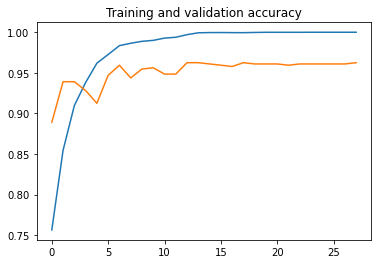

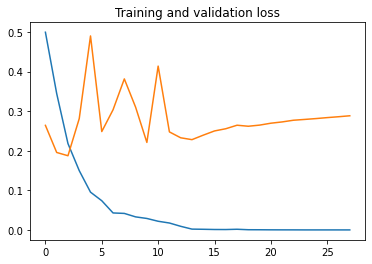

In [14]:
#plotting

import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history[ 'val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')

In [15]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [16]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [17]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

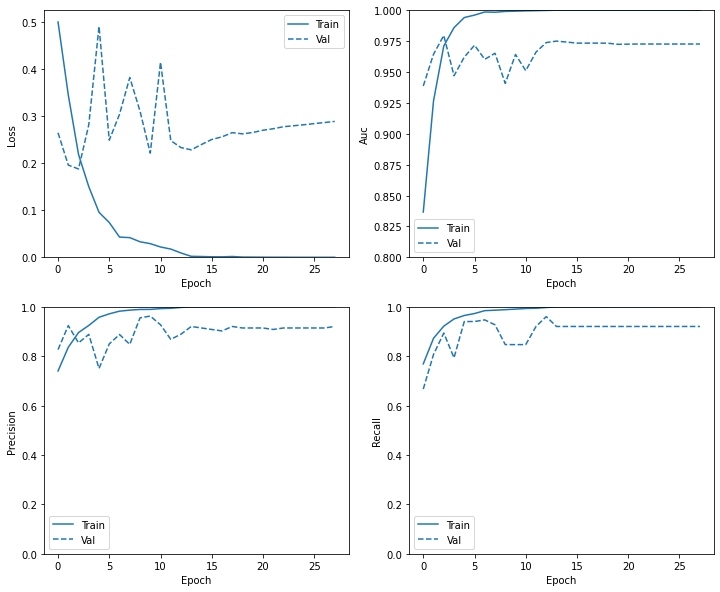

In [18]:
plot_metrics(history)


In [19]:
model.save('my_model.hdf5') 


In [20]:
def test_generator(samples, batch_size=1,shuffle_data=False):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        if (shuffle_data):
            shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples.iloc[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            

            # For each example
            for batch_sample in batch_samples.index:
                # Load image (X) and label (y)
                #print(batch_sample)
                
                img_path = samples.at[batch_sample, 'file_name']
                
                #label = to_categorical(label,len(df['english_cname'].unique()))
                #img =  cv2.imread(img_path)
                
                
                #if(when=='train'):
                #    print("{}         {}".format(batch_sample, np.argmax(label)))
                
                # apply any kind of preprocessing                
                #img = cv2.resize(img,(IMG_DIM, IMG_DIM))
                # Add example to arrays
                
                # AUGMENT DATA
                # load the image
                #img = load_img(img_path)
                img =  cv2.imread(img_path)
                img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT))
                #plt.imshow(img)
                # show the figure
                #pyplot.show()
                # convert to numpy array
                image_single = img_to_array(img)
                # expand dimension to one sample
                
                #if(when=='train'):
                image_single = expand_dims(image_single, 0)
                #print(samples.shape)
                # create image data augmentation generator
                

                # prepare iterator
                


                it = valid_datagen.flow(image_single, batch_size = 1)
                batch = it.next()
                image_single = batch[0].astype('float32')
               
                    # convert to unsigned integers for viewing
                
                    
                    # plot raw pixel data
                #plt.imshow(image)
                # show the figure
                #pyplot.show()
                
                
                
                
                X_train.append(image_single)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            #print("END__________")
            # The generator-y part: yield the next training batch            
            yield X_train

In [21]:
test_gen = test_generator(test_df, batch_size= 1, shuffle_data=False)


In [22]:
yhat=[]


In [23]:
probabilities = model.predict_generator(test_gen, steps = len(test_df), max_queue_size=1, verbose= 1)

1686/1686 [==============================] - 60s 35ms/step


In [ ]:
yhat = [1 if y > 0.5 else 0 for y in probabilities]

test_df['predicted'] = yhat

In [ ]:
from sklearn.metrics import accuracy_score


In [ ]:
accuracy_score(test_df['category'], test_df['predicted'])


In [ ]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [ ]:
plot_cm(test_df['category'], test_df['predicted'])
